In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from functools import reduce
from sklearn.preprocessing import OrdinalEncoder
from pgmpy.estimators import ExhaustiveSearch, K2Score, BicScore, HillClimbSearch
import networkx as nx

In [2]:
df = sns.load_dataset('car_crashes').drop("abbrev",axis=1)
df.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39
4,12.0,4.200,3.360,10.920,10.680,878.41,165.63


# Encontra Percentis

In [3]:
for c in df.columns:
    nome = str(c) + "_prct"
#     print(nome)

    q1 = df[c].quantile([.1])[.1]
    q2 = df[c].quantile([.4])[.4]
    q3 = df[c].quantile([.7])[.7]
    q4 = df[c].quantile([.95])[.95]
#     print([q1,q2,q3,q4])
    #renomeia

    df.loc[(df[c] <= q1),nome]="Menor igual a "+str(q1)
    df.loc[(df[c] > q1)&(df[c] <= q2),nome]="Entre "+str(q1)+" e "+str(q2)
    df.loc[(df[c] > q2)&(df[c] <= q3),nome]="Entre "+str(q2)+" e "+str(q3)
    df.loc[(df[c] > q3),nome]=f"Maior que "+str(q3) 

In [4]:
df_prct = df[[col for col in df.columns if "prct" in col]].copy()
df_prct.head()

,total_prct,speeding_prct,alcohol_prct,not_distracted_prct,no_previous_prct,ins_premium_prct,ins_losses_prct
0,Maior que 18.1,Maior que 6.0139999999999985,Maior que 5.456,Maior que 15.624,Entre 12.92 e 16.038,Entre 688.75 e 804.71,Entre 133.35 e 148.58
1,Entre 14.5 e 18.1,Maior que 6.0139999999999985,Entre 4.272 e 5.456,Maior que 15.624,Maior que 16.038,Maior que 913.15,Entre 133.35 e 148.58
2,Maior que 18.1,Maior que 6.0139999999999985,Entre 4.272 e 5.456,Entre 13.056 e 15.624,Maior que 16.038,Entre 804.71 e 913.15,Entre 106.62 e 133.35
3,Maior que 18.1,Entre 2.4130000000000003 e 4.095,Maior que 5.456,Maior que 15.624,Maior que 16.038,Entre 804.71 e 913.15,Entre 133.35 e 148.58
4,Entre 11.1 e 14.5,Entre 4.095 e 6.0139999999999985,Entre 3.3280000000000003 e 4.272,Entre 8.576 e 13.056,Entre 8.856 e 12.92,Entre 804.71 e 913.15,Maior que 148.58


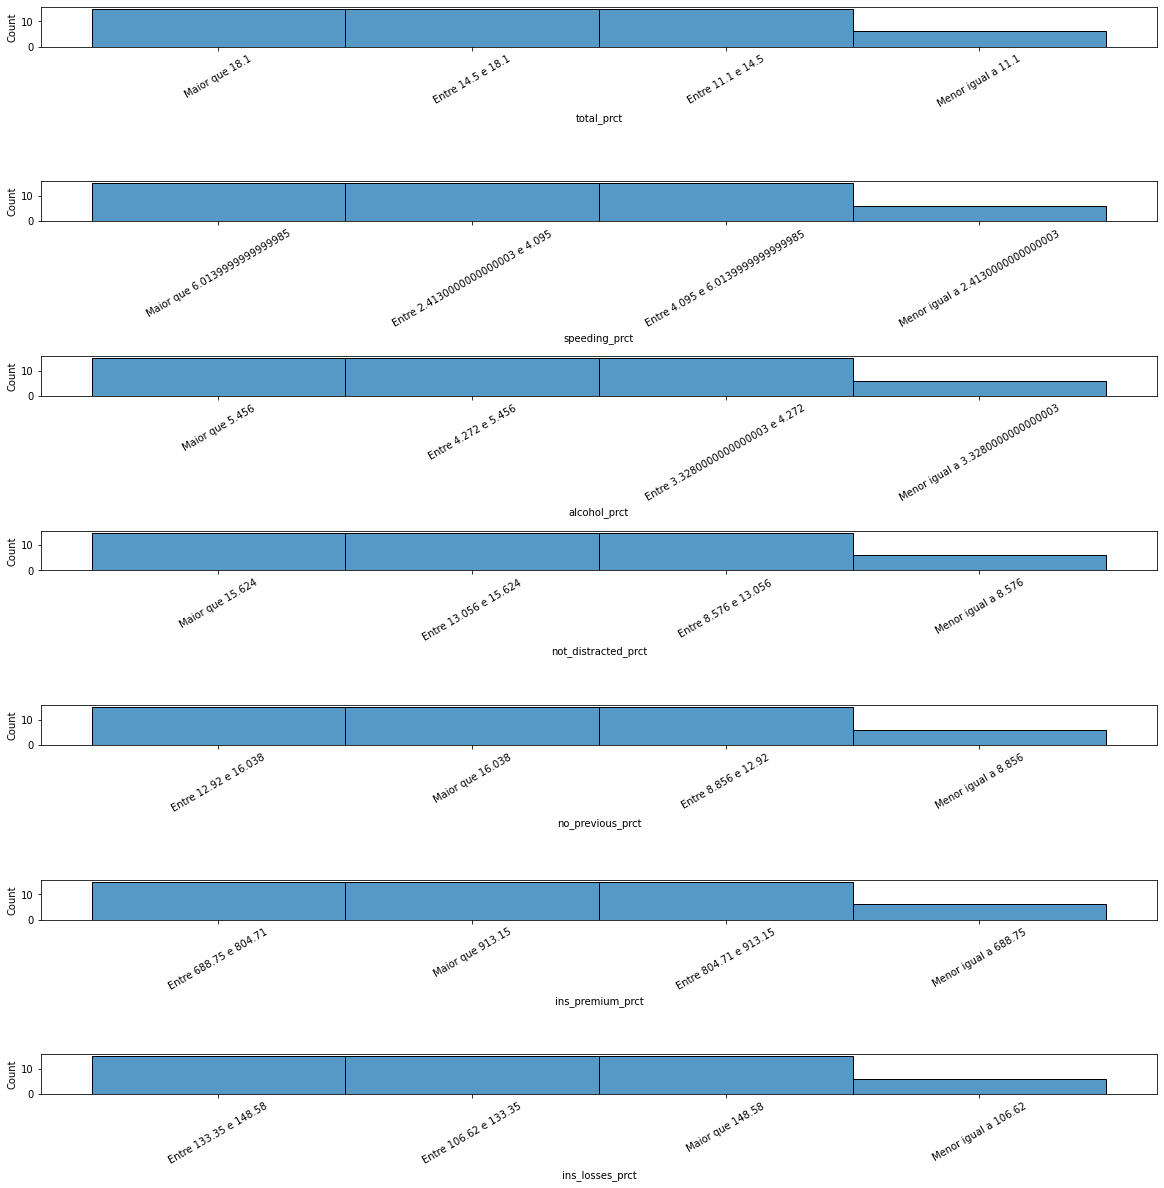

In [11]:
plt.figure(figsize=(20,20))
for c in enumerate(df_prct.columns):
    plt.subplot(len(df_prct.columns),1,c[0]+1)
    sns.histplot(data=df_prct,x=c[1])
    plt.xticks(rotation=30)
    plt.subplots_adjust(hspace=3.4)

In [13]:
est = HillClimbSearch(df_prct)

In [16]:
%%time
best_model=est.estimate(scoring_method=BicScore(df_prct))

  0%|                                                                           | 4/1000000 [00:00<18:23:51, 15.10it/s]

Wall time: 278 ms


In [17]:
best_model.edges()

OutEdgeView([('total_prct', 'no_previous_prct'), ('total_prct', 'not_distracted_prct'), ('speeding_prct', 'alcohol_prct'), ('alcohol_prct', 'total_prct')])

In [18]:
df_prct.head()

,total_prct,speeding_prct,alcohol_prct,not_distracted_prct,no_previous_prct,ins_premium_prct,ins_losses_prct
0,Maior que 18.1,Maior que 6.0139999999999985,Maior que 5.456,Maior que 15.624,Entre 12.92 e 16.038,Entre 688.75 e 804.71,Entre 133.35 e 148.58
1,Entre 14.5 e 18.1,Maior que 6.0139999999999985,Entre 4.272 e 5.456,Maior que 15.624,Maior que 16.038,Maior que 913.15,Entre 133.35 e 148.58
2,Maior que 18.1,Maior que 6.0139999999999985,Entre 4.272 e 5.456,Entre 13.056 e 15.624,Maior que 16.038,Entre 804.71 e 913.15,Entre 106.62 e 133.35
3,Maior que 18.1,Entre 2.4130000000000003 e 4.095,Maior que 5.456,Maior que 15.624,Maior que 16.038,Entre 804.71 e 913.15,Entre 133.35 e 148.58
4,Entre 11.1 e 14.5,Entre 4.095 e 6.0139999999999985,Entre 3.3280000000000003 e 4.272,Entre 8.576 e 13.056,Entre 8.856 e 12.92,Entre 804.71 e 913.15,Maior que 148.58


In [21]:
model = best_model
var_resp = ['total_prct','ins_losses_prct','ins_premium_prct']
color_map = []
for var in model.nodes():
    if var in var_resp:
        color_map.append('tab:green')
    else:
        color_map.append('tab:blue')

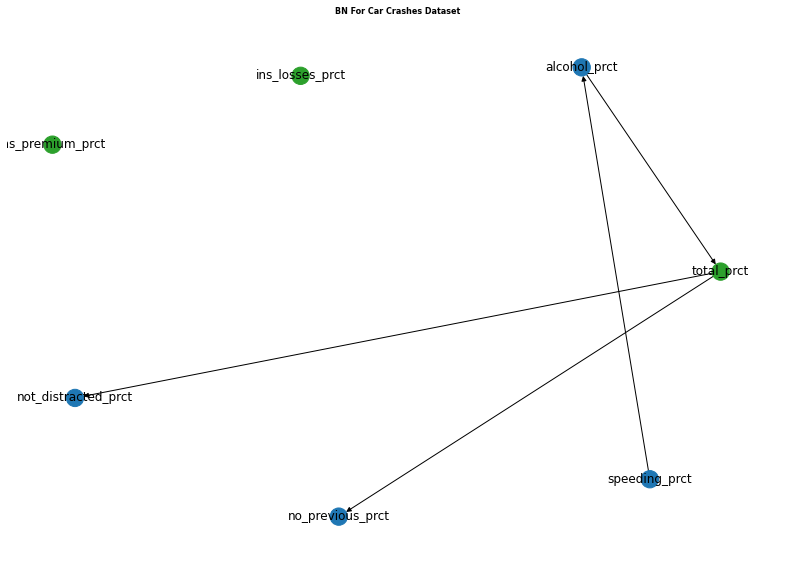

In [22]:
f,ax = plt.subplots(1,1,figsize=(14,10))
nx.draw(best_model,with_labels=True,ax=ax,node_color=color_map)
ax.set_title("BN For Car Crashes Dataset",
             fontweight='bold',
             fontsize=8)
plt.show()